In [1]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate,MaxPooling2D,BatchNormalization
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
import time
import random,pickle,cv2
from PIL import Image
from keras.regularizers import l2


Using TensorFlow backend.


In [3]:
files=['f/'+ x for x in os.listdir('../f/')]
labels=pickle.load(open('../fdata.pkl','rb'))
random.shuffle(files)
#val_files=files[:100]
#train_files=files[100:]
#pickle.dump(val_files,open('../fval_files.pkl','wb'))

In [4]:
val_files=pickle.load(open('../fval_files.pkl','rb'))
train_files=[f for f in files if f not in val_files ]
print(len(train_files),len(labels))

37555 37655


In [27]:

#Encoder
inputs = Input(shape=(299, 299,3,))

reg =None# l2(l=0.00001)
def primaryArch():
    output = Conv2D(32, (3,3), padding='same')(inputs)
    output=BatchNormalization(axis=-1)(output)
    output=Activation('relu')(output)
    
    output = Conv2D(32, (3,3), padding='same')(inputs)
    output=BatchNormalization(axis=-1)(output)
    output=Activation('relu')(output)
    output = keras.layers.MaxPool2D((2,2))(output)
    #output=keras.layers.Dropout(0.5)(output)
    output = Conv2D(64, (3,3), padding='same')(output)
    output=BatchNormalization(axis=-1)(output)
    output=Activation('relu')(output)
    #output=keras.layers.Dropout(0.5)(output)
    output = Conv2D(64, (3,3), padding='same')(output)
    output=BatchNormalization(axis=-1)(output)
    output=Activation('relu')(output)
    output = keras.layers.MaxPool2D((2,2))(output)
    output = Conv2D(128, (3,3), padding='same')(output)
    output=BatchNormalization(axis=-1)(output)
    output=Activation('relu')(output)
    #output=keras.layers.Dropout(0.5)(output)
    #output=BatchNormalization(axis=-1)(output)
    output = Conv2D(128, (3,3), padding='same')(output)
    output=BatchNormalization(axis=-1)(output)
    output=Activation('relu')(output)
    output = keras.layers.MaxPool2D((2,2))(output)
    #output=keras.layers.Dropout(0.25)(output)
    output = Conv2D(256, (3,3), padding='same')(output)
    output=BatchNormalization(axis=-1)(output)
    output=Activation('relu')(output)
    #output=keras.layers.Dropout(0.5)(output)
    #output=BatchNormalization(axis=-1)(output)
    output = Conv2D(256, (3,3), padding='same')(output)
    output=BatchNormalization(axis=-1)(output)
    output=Activation('relu')(output)
    
    output = keras.layers.MaxPool2D((2,2))(output)
    #output=keras.layers.Dropout(0.25)(output)
    output = Conv2D(512, (3,3), padding='same')(output)
    output=BatchNormalization(axis=-1)(output)
    output=Activation('relu')(output)
    output = Conv2D(512, (3,3), padding='same')(output)
    output=BatchNormalization(axis=-1)(output)
    output=Activation('relu')(output)
    output = keras.layers.MaxPool2D((2,2))(output)
    #output=keras.layers.Dropout(0.25)(output)
    output = Reshape(([81*512]))(output)

    return output

#x1=keras.applications.xception.Xception(include_top=True, weights='imagenet', input_tensor=None, input_shape=(299,299,3), pooling=None, classes=1000)

output1=primaryArch()
output1=keras.layers.Dropout(0.2)(output1)
output1 = Dense(768,activation='relu',kernel_regularizer=reg)(output1)
output1=keras.layers.Dropout(0.2)(output1)
output1 = Dense(512,activation='relu',kernel_regularizer=reg)(output1)
output1=keras.layers.Dropout(0.2,)(output1)
output1 = Dense(100,activation='relu',kernel_regularizer=reg)(output1)
output1=keras.layers.Dropout(0.2)(output1)

predictions1 = Dense(1, activation='sigmoid',kernel_regularizer=reg)(output1)



model = Model(inputs=inputs ,outputs=predictions1)

#model = Model(inputs=[input,embed_input], outputs=output)

In [31]:
for x in model.layers[:-8]:
    x.trainable=False

Generators

In [32]:

batch_size = 15

def train_gen(batch_size):
    while True:
        #print('tgen')
        i=random.randint(0,len(train_files)-batch_size-1)
        names=train_files[i:i+batch_size]
        X_batch, Y_batch=generator(names,labels)
        yield (X_batch, Y_batch)
        
def val_gen():
    names=val_files
    
    X_batch, Y_batch=generator(names,labels)
    while True:
            #print('vgen')
            yield (X_batch,Y_batch)

def cv_val_gen():
    #print('cvgen')
    names=val_files
    X_batch, Y_batch=generator(cv_val_files,cv_val_labels,True)
    return X_batch,Y_batch
def generator(names,labels,cv_val=False):
    X_batch=[]
    Y_batch=[]
    embed=[]
    for filename in names:
        image=[]
        img=Image.open('../'+filename)
        X_batch.append(np.array(img))
        d=0
        if(len(labels[filename])>0):    
            Y_batch.append(1)
        else:   
            Y_batch.append(0)
     
    X_batch=np.array(X_batch)
    Y_batch=np.array(Y_batch)
    #embed=create_inception_embedding(X_batch)
    return X_batch, Y_batch





In [33]:
def f2_score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.cast(K.greater(K.clip(y_true * y_pred, 0, 1),0.5),'float32'))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.cast(K.greater(K.clip(y_true * y_pred, 0, 1),0.5),'float32'))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def loss(y_true, y_pred):
    #A=y_pred[:,1]*y_true[:,0]
    #B=y_pred[:,2]*y_true[:,0]
    #a=10*K.sum(K.square(A-y_true[:,1]))+10*K.sum(K.square(B-y_true[:,2]))+K.sum(K.square((1-y_pred[:,0])-(1-y_true[:,0])))
    return keras.losses.binary_crossentropy(y_true,y_pred)

def loss2(y_true, y_pred):
    A=y_pred[:,0]*y_true[:,0]
    B=y_pred[:,1]*y_true[:,0]
    a=K.sum(K.square(A-y_true[:,1]))+K.sum(K.square(B-y_true[:,2]))
    return a

def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper


##### below class was used for another validation set, much tougher than currently used

In [34]:

class AdditionalValidationSets(keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [2, 3]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for i, result in enumerate(results):
                if i == 0:
                    valuename = validation_set_name + '_loss'
                else:
                    valuename = validation_set_name + '_' + self.model.metrics[i-1].__name__
                print(valuename,result)
                self.history.setdefault(valuename, []).append(result)

In [39]:
modelsaver=keras.callbacks.ModelCheckpoint('/media/arpit/New Volume/Datasets/skylark/tmp/model-{epoch:02d}-{val_loss:.2f}.hdf5',verbose=True, mode='auto', period=10)
adam=keras.optimizers.Adam(lr=0.0001)
sgd = keras.optimizers.SGD(lr=0.0000001, decay=1e-8, momentum=0.9, nesterov=True)

losses={
    'dense_4':'binary_crossentropy',
    #'dense_8':loss2
}
tensorboard = TensorBoard(log_dir="./output")
model.compile(optimizer=sgd, loss='binary_crossentropy',metrics=[f2_score])

#### Linear decay

In [42]:
def exp_decay(step):
   initial_lrate = 0.00001
   final_lrate=0.00001
   lrate = (initial_lrate-final_lrate)*step/300
   return initial_lrate

lrate = keras.callbacks.LearningRateScheduler(exp_decay)

In [ ]:


#Train model      

model.fit_generator(train_gen(batch_size), epochs=300,callbacks=[modelsaver,tensorboard],steps_per_epoch=40,validation_data=val_gen(),validation_steps=1, max_queue_size=15)

Epoch 1/300
1e-06
40/40 [==============================] - 9s 224ms/step - loss: 0.1655 - f2_score: 0.9200 - val_loss: 0.1378 - val_f2_score: 0.9541
Epoch 2/300
1e-06
40/40 [==============================] - 9s 213ms/step - loss: 0.1603 - f2_score: 0.9297 - val_loss: 0.1378 - val_f2_score: 0.9541
Epoch 3/300
1e-06
40/40 [==============================] - 8s 200ms/step - loss: 0.1778 - f2_score: 0.9373 - val_loss: 0.1378 - val_f2_score: 0.9541
Epoch 4/300
1e-06
40/40 [==============================] - 9s 231ms/step - loss: 0.1744 - f2_score: 0.9258 - val_loss: 0.1378 - val_f2_score: 0.9541
Epoch 5/300
1e-06
40/40 [==============================] - 8s 210ms/step - loss: 0.1393 - f2_score: 0.9325 - val_loss: 0.1378 - val_f2_score: 0.9541
Epoch 6/300
1e-06
40/40 [==============================] - 8s 201ms/step - loss: 0.1608 - f2_score: 0.9243 - val_loss: 0.1378 - val_f2_score: 0.9541

Epoch 00006: saving model to /media/arpit/New Volume/Datasets/skylark/tmp/model-06-0.14.hdf5
Epoch 7/300


40/40 [==============================] - 8s 211ms/step - loss: 0.1631 - f2_score: 0.9420 - val_loss: 0.1380 - val_f2_score: 0.9541
Epoch 104/300
1e-06
40/40 [==============================] - 8s 202ms/step - loss: 0.1734 - f2_score: 0.9325 - val_loss: 0.1380 - val_f2_score: 0.9541
Epoch 105/300
1e-06
40/40 [==============================] - 8s 197ms/step - loss: 0.1458 - f2_score: 0.9216 - val_loss: 0.1381 - val_f2_score: 0.9541
Epoch 106/300
1e-06
40/40 [==============================] - 7s 185ms/step - loss: 0.1967 - f2_score: 0.9212 - val_loss: 0.1381 - val_f2_score: 0.9541

Epoch 00106: saving model to /media/arpit/New Volume/Datasets/skylark/tmp/model-106-0.14.hdf5
Epoch 107/300
1e-06
40/40 [==============================] - 8s 191ms/step - loss: 0.1702 - f2_score: 0.9323 - val_loss: 0.1381 - val_f2_score: 0.9541
Epoch 108/300
1e-06
40/40 [==============================] - 9s 222ms/step - loss: 0.1817 - f2_score: 0.9306 - val_loss: 0.1381 - val_f2_score: 0.9541
Epoch 109/300
1e-06

In [ ]:
model.save('model5.hdf5')

In [29]:
model.load_weights('model5.hdf5')

In [ ]:
x,y=next(train_gen(50))
Y=model.predict(x)
Y=np.round(Y).astype(int)
if Y[0]>0.5:
    print("found",Y[0])

plt.imshow(x[0])
print(precision_score(y,Y),recall_score(y,Y),f1_score(y,Y))

In [14]:
def plotRec(vec,Y):
    index=np.argsort(Y,axis=0)[::-1]
    print(Y[index][:15])
    x=vec[index[:,0],:,:,1]
    print(x.shape)
    return x


144 145 93 93
[[[0.44064564]]

 [[0.32599592]]

 [[0.29978195]]

 [[0.27245617]]

 [[0.25920004]]

 [[0.21872428]]

 [[0.20783031]]

 [[0.20268428]]

 [[0.19097789]]

 [[0.17747779]]

 [[0.14217427]]

 [[0.13508579]]

 [[0.11507339]]

 [[0.10989936]]

 [[0.10451925]]]
(154, 299, 299)
(154, 299, 299)


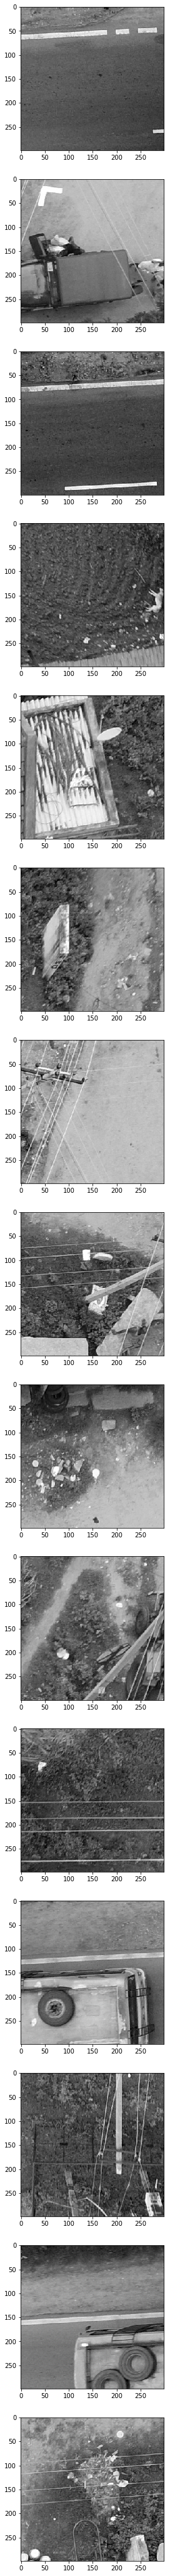

In [24]:
def manipulateImage(img):
    height=299*(1+(img.shape[0]//299))
    width=299*(1+(img.shape[1]//299))
    h=height-img.shape[0]
    w=width-img.shape[1]
    print( h//2, h-(h//2), w//2, w-(w//2))
    image = cv2.copyMakeBorder( img, h//2, h-(h//2), w//2, w-(w//2), cv2.BORDER_CONSTANT)
    vec=[]
    for x in range(width//299):
        for y in range(height//299):
            im=[]
            img=image[299*y:299*(y+1),299*x:299*(x+1)]
            im.append(img)
            
    return np.array(vec)

name='DJI_0036'
vec=manipulateImage(cv2.imread('../CV-Assignment-Dataset/'+name+'.JPG')/255)


vec=plotRec(vec,model.predict(vec))
i=0
print(vec.shape)
f=plt.figure(figsize=(10,15*5))
i=1
for x in vec[:15]:
    f.add_subplot(15,1,i)
    plt.imshow(np.squeeze(x),cmap='gray')
    i+=1

    #     time.sleep(3)
    